In [2]:
import os
import numpy as np
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, f1_score, recall_score, cohen_kappa_score,
    accuracy_score, classification_report
)
from sklearn.neighbors import kneighbors_graph
from collections import defaultdict

In [3]:
# Set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# Load dataset
data = scipy.io.loadmat("/content/drive/MyDrive/Indian_pines_corrected.mat")['indian_pines_corrected']
labels = scipy.io.loadmat("/content/drive/MyDrive/Indian_pines_gt.mat")['indian_pines_gt']

X: (21025, 200) — each pixel becomes a 200-dimensional vector.<br>
y: (21025,) — each pixel has one class label.



In [5]:
H, W, C = data.shape
X = data.reshape(-1, C)
y = labels.flatten()

Normalize all features to have zero mean and unit variance.

In [6]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Build coordinates
coords = np.array([[i // W, i % W] for i in range(H * W)])

In [8]:
# KNN Graph construction
adj = kneighbors_graph(coords, n_neighbors=8, include_self=True)

In [9]:
def normalize_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv = sp.diags(d_inv_sqrt)
    return D_inv @ adj @ D_inv

In [10]:
adj = normalize_adj(adj)
adj = adj.tocoo()
adj = torch.sparse_coo_tensor(
    torch.LongTensor(np.vstack((adj.row, adj.col))),
    torch.FloatTensor(adj.data),
    torch.Size(adj.shape)
)

Ignoring pixels with label 0 (i.e., unlabeled).

Subtract 1 to make classes range from 0 to 15.
**bold text**

In [11]:
# Only labeled data
mask = y > 0
X_labeled = X[mask]
y_labeled = y[mask] - 1
coords_labeled = coords[mask]
indices_labeled = np.where(mask)[0]

In [12]:
# Stratified random sampling (30 per class or all if less)

# Paper-specific sample counts
class_train_counts = {
    0: 30,   # Alfalfa
    1: 30,   # Corn-notill
    2: 30,   # Corn-mintill
    3: 30,   # Corn
    4: 30,   # Grass-pasture
    5: 30,   # Grass-trees
    6: 14,   # Grass-pasture-mowed
    7: 30,   # Hay-windrowed
    8: 10,   # Oats
    9: 30,   # Soybean-notill
    10: 30,  # Soybean-mintill
    11: 30,  # Soybean-clean
    12: 30,  # Wheat
    13: 30,  # Woods
    14: 30,  # Buildings-Grass-Trees-Drives
    15: 30   # Stone-Steel-Towers
}

train_idx, test_idx = [], []
np.random.seed(42)

for class_label, train_count in class_train_counts.items():
    indices = np.where(y_labeled == class_label)[0]
    np.random.shuffle(indices)

    train_idx.extend(indices[:train_count])
    test_idx.extend(indices[train_count:])

In [13]:
# Build tensor structures

# Convert full feature matrix and label array to PyTorch tensors.
features = torch.FloatTensor(X)
labels_full = torch.LongTensor(y-1)

# Masks indicate which pixels are used for training and testing.
train_mask = torch.zeros(H * W, dtype=torch.bool)
test_mask = torch.zeros(H * W, dtype=torch.bool)
num_labeled = len(indices_labeled)#counting how many pixels/nodes in your dataset actually have labels
num_train = int(0.1 * num_labeled)  # Adjust the percentage as needed
train_global_idx = indices_labeled[np.random.choice(num_labeled, num_train, replace=False)]
test_global_idx = np.setdiff1d(indices_labeled, train_global_idx)
train_mask[train_global_idx] = True
test_mask[test_global_idx] = True

Each GCN layer is essentially:
<br>
H^(l): input features
<br>
W^(l): learnable weights (self.linear)
<br>
\hat{A}: normalized adjacency matrix

 x (features):
Shape: [N, F_in]<br>
N = 21025 (each node = one pixel in H×W)<br>
F_in = 200 (number of features per pixel)<br>
Example: x.shape = [21025, 200]

adj (adjacency matrix):<br>
Shape: [N, N] = [21025, 21025]<br>
Type: sparse PyTorch tensor

In [14]:
# GCN Model
class GCNLayer(nn.Module):  # one GCN layer
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        return self.linear(torch.sparse.mm(adj, x))
# Multiply input features with the graph structure first (adjmatrix x nodefeatures)
# adj: (N, N)
# x: (N, F_in)
# Result: (N, F_in) this goes as input
#Output: (N, F_out)




"""Two-layer GCN:
First layer: input → hidden
Second layer: hidden → output
Optional dropout in between."""

class GCN(nn.Module):  # two GCN layer
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)  #Input feature shape:(21025,200)
        self.gcn2 = GCNLayer(hidden_dim, output_dim) #hidden=128,output=16
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj)) #Input shape:(21025,200), Output:(21025,128)
        x = F.dropout(x, self.dropout, self.training)
        x = self.gcn2(x, adj) #Input: (21025, 128), Final Output: (21025, 16)
        return x

"""Forward pass:
GCN Layer 1 → ReLU
Dropout (only during training)
GCN Layer 2 → logits"""

""" Each layer aggregates features from its neighbors and applies
a transformation"""

' Each layer aggregates features from its neighbors and applies \na transformation'

In [15]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_dim=C, hidden_dim=128, output_dim=16).to(device)
features = features.to(device)
adj = adj.to(device)
labels_full = labels_full.to(device)
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

Every epoch:
<br>
Forward pass
<br>
Compute loss on train_mask samples
<br>
Backprop and optimizer step
<br>
Evaluate on test set using test_mask

In [17]:
# Training loop
best_acc = 0
patience = 20
trigger = 0
losses, val_accuracies, train_accuracies = [], [], []
best_model = None

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(features, adj)
    loss = criterion(out[train_mask], labels_full[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(features, adj)
        val_preds = logits[test_mask].argmax(dim=1)
        val_acc = (val_preds == labels_full[test_mask]).float().mean().item()

        train_preds = logits[train_mask].argmax(dim=1)
        train_acc = (train_preds == labels_full[train_mask]).float().mean().item()

    losses.append(loss.item())
    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        trigger = 0
        best_model = model.state_dict()
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break

Epoch 1: Loss=2.7753, Train Acc=42.29%, Val Acc=40.63%
Epoch 2: Loss=2.0373, Train Acc=38.28%, Val Acc=36.89%
Epoch 3: Loss=1.8226, Train Acc=41.41%, Val Acc=40.96%
Epoch 4: Loss=1.6814, Train Acc=44.82%, Val Acc=42.70%
Epoch 5: Loss=1.5706, Train Acc=46.48%, Val Acc=43.98%
Epoch 6: Loss=1.5180, Train Acc=48.83%, Val Acc=46.99%
Epoch 7: Loss=1.5118, Train Acc=49.80%, Val Acc=47.85%
Epoch 8: Loss=1.4546, Train Acc=52.93%, Val Acc=50.19%
Epoch 9: Loss=1.4026, Train Acc=53.71%, Val Acc=51.70%
Epoch 10: Loss=1.3566, Train Acc=55.27%, Val Acc=53.12%
Epoch 11: Loss=1.3321, Train Acc=56.35%, Val Acc=55.09%
Epoch 12: Loss=1.2894, Train Acc=54.10%, Val Acc=53.32%
Epoch 13: Loss=1.2984, Train Acc=56.45%, Val Acc=55.82%
Epoch 14: Loss=1.2821, Train Acc=56.25%, Val Acc=55.20%
Epoch 15: Loss=1.2370, Train Acc=57.13%, Val Acc=56.21%
Epoch 16: Loss=1.2285, Train Acc=58.20%, Val Acc=56.47%
Epoch 17: Loss=1.2363, Train Acc=58.50%, Val Acc=56.96%
Epoch 18: Loss=1.1976, Train Acc=59.47%, Val Acc=59.09%
E

In [18]:
# Restore best model
model.load_state_dict(best_model)
model.eval()

GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=200, out_features=128, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [19]:
# Evaluation
with torch.no_grad():
    final_preds = model(features, adj)[test_mask].argmax(dim=1).cpu().numpy()
    true_labels = labels_full[test_mask].cpu().numpy()

conf_mat = confusion_matrix(true_labels, final_preds)
per_class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
f1 = f1_score(true_labels, final_preds, average='weighted')
recall = recall_score(true_labels, final_preds, average='weighted')
kappa = cohen_kappa_score(true_labels, final_preds)
oa = accuracy_score(true_labels, final_preds)
aa = per_class_acc.mean()

In [20]:
print("\nClass-wise Accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"Class {i+1}: {acc*100:.2f}%")


Class-wise Accuracy:
Class 1: 69.77%
Class 2: 90.34%
Class 3: 84.24%
Class 4: 94.47%
Class 5: 98.38%
Class 6: 99.25%
Class 7: 95.83%
Class 8: 100.00%
Class 9: 31.58%
Class 10: 94.74%
Class 11: 96.13%
Class 12: 82.47%
Class 13: 98.94%
Class 14: 99.12%
Class 15: 82.62%
Class 16: 98.85%


In [21]:
print("\nFinal Metrics:")
print(f"OA: {oa*100:.2f}% | AA: {aa*100:.2f}% | F1: {f1:.4f} | Recall: {recall:.4f} | Kappa: {kappa:.4f}")


Final Metrics:
OA: 93.57% | AA: 88.55% | F1: 0.9350 | Recall: 0.9357 | Kappa: 0.9267


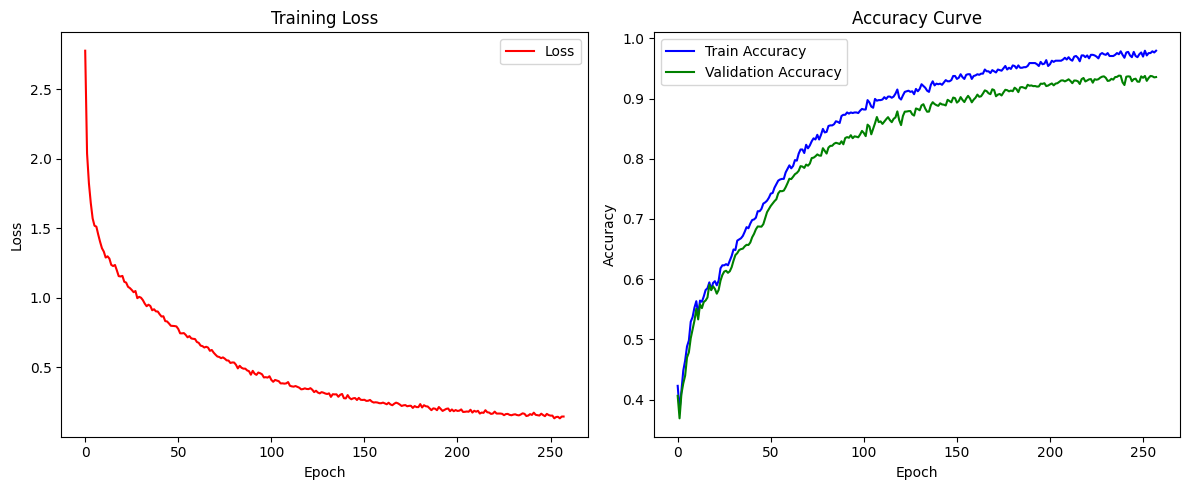

In [22]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

In [23]:
print("Train indices:", torch.nonzero(train_mask, as_tuple=True)[0])
print("Test indices:", torch.nonzero(test_mask, as_tuple=True)[0])


Train indices: tensor([    1,    79,    82,  ..., 20486, 20491, 20620])
Test indices: tensor([    0,     2,     3,  ..., 20765, 20766, 20767])


In [ ]:
import pandas as pd

# Assuming per_class_acc is already defined
class_names = [
    "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture",
    "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", "Oats",
    "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat",
    "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"
]

# Create DataFrame
accuracy_df = pd.DataFrame({
    "Class No.": list(range(1, len(per_class_acc) + 1)),
    "Class Name": class_names,
    "Accuracy (%)": [round(acc * 100, 2) for acc in per_class_acc]
})

# Save to Excel
accuracy_df.to_excel("class_wise_accuracy.xlsx", index=False)

print("✅ Class-wise accuracy saved to 'class_wise_accuracy.xlsx'")


In [ ]:
# Save
torch.save(model.state_dict(), "gcn_model_weights.pth")
print("✅ Model weights saved!")

# Load
model.load_state_dict(torch.load("gcn_model_weights.pth"))
model.eval()  # Put model in evaluation mode


In [ ]:
torch.save(model, "gcn_full_model.pth")
print("✅ Full model saved!")


In [ ]:
import torch
# from your_model_file import GCN  # <- make sure you import GCN class!

torch.serialization.add_safe_globals({'GCN': GCN})

model = torch.load("gcn_full_model.pth", weights_only=False)
model.eval()


In [24]:
import numpy as np
from collections import Counter

train_labels = y_labeled[train_idx]
test_labels = y_labeled[test_idx]

print("Train distribution:", dict(Counter(train_labels)))
print("Test distribution:", dict(Counter(test_labels)))
print("Total train:", len(train_idx))
print("Total test:", len(test_idx))


Train distribution: {np.uint8(0): 30, np.uint8(1): 30, np.uint8(2): 30, np.uint8(3): 30, np.uint8(4): 30, np.uint8(5): 30, np.uint8(6): 14, np.uint8(7): 30, np.uint8(8): 10, np.uint8(9): 30, np.uint8(10): 30, np.uint8(11): 30, np.uint8(12): 30, np.uint8(13): 30, np.uint8(14): 30, np.uint8(15): 30}
Test distribution: {np.uint8(0): 16, np.uint8(1): 1398, np.uint8(2): 800, np.uint8(3): 207, np.uint8(4): 453, np.uint8(5): 700, np.uint8(6): 14, np.uint8(7): 448, np.uint8(8): 10, np.uint8(9): 942, np.uint8(10): 2425, np.uint8(11): 563, np.uint8(12): 175, np.uint8(13): 1235, np.uint8(14): 356, np.uint8(15): 63}
Total train: 444
Total test: 9805
